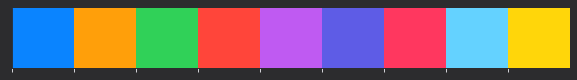

In [1]:
import time
import logging
import os
import glob
import json
import re
import random
import textwrap
from termcolor import colored
from pathlib import Path
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split

import tensorflow as tf

import torch
from torch.utils.data import Dataset,DataLoader
import pytorch_lightning as pl

%matplotlib inline

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]
raw_darks=[
    (44, 44, 46)
]
raw_lights=[
    (229, 229, 234)
]
miscellaneous={
    'blue':'#0f71d4',
    'green':'#14b827',
    'red':'#cf0c0c'
}

dark_palette=np.array(raw_dark_palette)/255
darks=np.array(raw_darks)/255
lights=np.array(raw_lights)/255

#rcparams
dark_color=darks[-1]
light_color=lights[-1]

mpl.rcParams['axes.prop_cycle']=cycler('color',dark_palette)
mpl.rcParams['figure.facecolor']=dark_color
mpl.rcParams['figure.edgecolor']=dark_color
mpl.rcParams['axes.facecolor']=dark_color
mpl.rcParams['text.color']=light_color
mpl.rcParams['axes.labelcolor']=light_color
mpl.rcParams['axes.edgecolor']=dark_color
mpl.rcParams['xtick.color']=light_color
mpl.rcParams['ytick.color']=light_color
mpl.rcParams['figure.dpi']=80
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

sns.palplot(dark_palette)

In [15]:
data_dir='data/Binance_BTCUSDT_minute.csv'
df=pd.read_csv(data_dir,parse_dates=['date'],header=1)
df=df.sort_values(by='date').reset_index(drop=True)
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1567965420000,2019-09-08 17:57:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.001,10.0,1
1,1567965480000,2019-09-08 17:58:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0
2,1567965540000,2019-09-08 17:59:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.001,10.0,1
3,1567965600000,2019-09-08 18:00:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0
4,1567965660000,2019-09-08 18:01:00,BTC/USDT,10000.0,10000.0,10000.0,10000.0,0.000,0.0,0
